In [1]:
import os
import sys
main_path = os.path.abspath(os.path.join(os.path.dirname("./resolution_search.ipynb"), '..'))
print(main_path)
sys.path.insert(0, main_path)
from src.preprocesing import get_mmbopf_plasticc_path, rearrange_splits, gen_dataset_from_h5
from src.mmmbopf.method import MMMBOPF

import numpy as np
import pandas as pd
import seaborn as snb
import matplotlib.pyplot as plt
import json
plt.style.use('seaborn')

data_path = get_mmbopf_plasticc_path()
print(data_path)
resolution_search_main_directory = os.path.join(data_path, "resolution_search")
print(resolution_search_main_directory)

D:\tesis
../data/plasticc/MMMBOPF
../data/plasticc/MMMBOPF\resolution_search


In [2]:
folder = os.path.join(resolution_search_main_directory, "lsa", "lsa_resolution_search")
file1 = "multi_ress_(TrMm-MmMn-MmMx-TrMn)_20210914-031605.csv"
file2 = "multi_ress_(TrMmMn-MmVaMx)_20210914-031605.csv"

In [3]:
df1 = pd.read_csv(os.path.join(folder, file1))

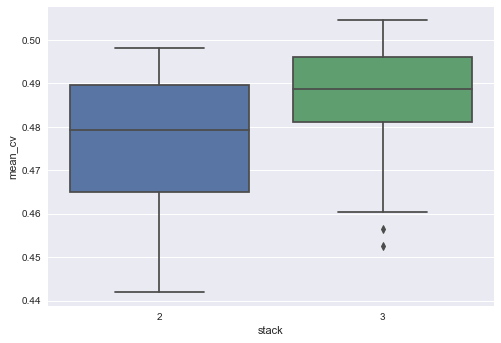

In [4]:
b = snb.boxplot(x="stack", y="mean_cv", data=df1[df1["top-k"]==2])

In [5]:
df11 = df1[df1["top-k"]==1]
np.unique(df11["stack"])

array([2, 3], dtype=int64)

In [6]:
def sort_quantities_by_acc(df):
    quantities = np.unique(df["quantity"])
    Q = []
    acc = []
    wl = []
    win = []
    for q in quantities:
        df_i = df[df["quantity"] == q]
        acc_i = df_i["cv_mean"].to_numpy()
        wl_i = df_i["wl"].to_numpy()
        win_i = df_i["win"].to_numpy()
        
        idx = np.argmax(acc_i)
        
        acc.append(float(acc_i[idx]))
        wl.append(int(wl_i[idx]))
        win.append(float(win_i[idx]))
        Q.append(str(q))
        
    return Q, acc, wl, win

def add_count_Qs(df):
    df["count_Qs"] = [len(x.split("-")) for x in df["quantity"]]
    return df
    
def comb_filter_only_bests(df, n_max):
    df2 = df[df["count_Qs"] == 2]
    cv_mean = df2["cv_mean"].to_numpy()
    highest_idx = np.argmax(cv_mean)
    line = df2.iloc[highest_idx]
    df_filter = ((df["count_Qs"] == 2) & (df2["quantity"] == line.quantity))
    for i in range(3,n_max):
        df2 = df[df["count_Qs"] == i]
        cv_mean = df2["cv_mean"].to_numpy()
        highest_idx = np.argmax(cv_mean)
        line = df2.iloc[highest_idx]
        df_filter |= ((df["count_Qs"] == i) & (df2["quantity"] == line.quantity))
    
    return df[df_filter]

def concat_single_best(df1, df2):
    cv_mean = df1["cv_mean"].to_numpy()
    highest_idx = np.argmax(cv_mean)
    highest_Q = df1.iloc[highest_idx].quantity
    df3 = df1[df1["quantity"] == highest_Q]
    return pd.concat([df3, df2])

def a():
    folder = os.path.join(main_path, "data", "quantity_search")
    
    filename = "double_quantity_lsa_20210903-044949"
    df_double_q = pd.read_csv(os.path.join(folder, filename), index_col=None)
    df_double_q = df_double_q[df_double_q["valid_cv"]]
    add_count_Qs(df_double_q)
    df_double_q = df_double_q[df_double_q["quantity"] != "(MmTr)"]
    df_double_q.head()

    filename = "comb_double_quantity_lsa_20210904-024910"
    df_comb_double_q = pd.read_csv(os.path.join(folder, filename), index_col=None)
    df_comb_double_q = df_comb_double_q[df_comb_double_q["valid_cv"]]
    add_count_Qs(df_comb_double_q)
    df_comb_double_q2 = comb_filter_only_bests(df_comb_double_q, 6)
    df_comb_double_q2 = concat_single_best(df_double_q, df_comb_double_q2)
    df_comb_double_q2.head()
    
    return df_comb_double_q2  
df_stack1 = a()
df_stack1 = df_stack1[df_stack1["quantity"] == "(MmTr-MmMn-MmMx-TrMn)"]

In [7]:
df_stack1.sort_values("cv_mean", ascending=False).iloc[0]["cv_mean"]

0.486

In [8]:
def plot_resolution(df, ax, val_name, prev_resolution = "", stack=1):
    formats = ["--o", "--v", "--P"]
    highest_acc = -1
    max_resolution = ""
    for wl, fmt in zip(np.unique(df["wl"].to_numpy()), formats):
        df_tmp = df[df["wl"]==wl].sort_values("win")
        df_best_line = df_tmp.sort_values(val_name, ascending=False).iloc[0]
        
        if df_best_line[val_name] > highest_acc:
            highest_acc = df_best_line[val_name]
            max_resolution = "(%s, %s)" % (str(df_best_line["win"]), str(df_best_line["wl"]))
        vals = df_tmp[val_name].to_numpy()
        yerrs = df_tmp["std_cv" if val_name=="mean_cv" else "cv_std"].to_numpy()
        wins = df_tmp["win"].to_numpy()
        ax.errorbar(wins, vals, yerr=yerrs, fmt=fmt, label="%s-symbol words" % wl)
    if len(prev_resolution) > 0:
        new_max_res = ", ".join([prev_resolution, max_resolution])
    else:
        new_max_res = max_resolution
    ax.set_title("%s-levels of resolution, highest: [%s], acc: %.03f" % (stack, new_max_res, highest_acc), fontsize=16)
    ax.set_ylabel("Balanced accuracy", fontsize=15)
    ax.yaxis.set_tick_params(labelsize=14)
    ax.xaxis.set_tick_params(labelsize=14)
    return new_max_res
#     ax.axhline(highest_acc, color="k", alpha=0.5)

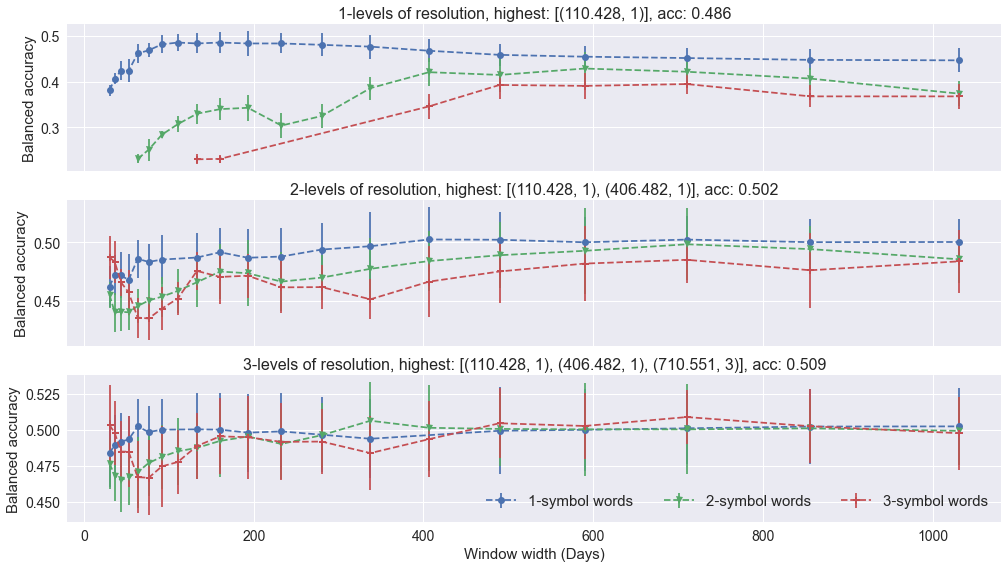

In [9]:
fig, ax = plt.subplots(3, 1, figsize=(14, 8), sharex=True)
prev_resolution = ""
prev_resolution = plot_resolution(df_stack1, ax[0], "cv_mean", stack=1, prev_resolution=prev_resolution)

prev_resolution = plot_resolution(df11[df11["stack"]==2], ax[1], "mean_cv", stack=2, prev_resolution=prev_resolution)

prev_resolution = plot_resolution(df11[df11["stack"]==3], ax[2], "mean_cv", stack=3, prev_resolution=prev_resolution)

box = ax[2].get_position()
# ax[2].set_position([box.x0, box.y0 + box.height * 0.1,
#                  box.width, box.height * 0.9])

# Put a legend below current axis
ax[2].legend(loc='lower right', fancybox=True, shadow=True, ncol=5, fontsize=15)

ax[2].set_xlabel("Window width (Days)", fontsize=15)

plt.tight_layout()
# plt.subplots_adjust(hspace=0.03)
plt.savefig("figs/resolution_search_resume.png", dpi=300)

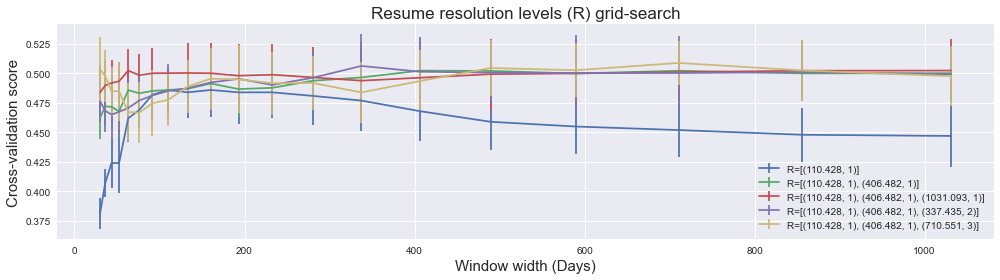

In [10]:
fig = plt.figure(figsize=(14, 4))
df_tmp1 = df_stack1[df_stack1["wl"]==1]
df_tmp_lbl = df_tmp1.sort_values("cv_mean", ascending=False).iloc[0]
lbl_inside = "(%s, %s)" % (str(df_tmp_lbl["win"]), str(df_tmp_lbl["wl"]))
plt.errorbar(df_tmp1["win"], df_tmp1["cv_mean"], yerr=df_tmp1["cv_std"], label="R=[%s]" % lbl_inside)

df_tmp2 = df11[df11["stack"]==2].sort_values("win", ascending=False)
df_tmp2 = df_tmp2[df_tmp2["wl"]==1]
df_tmp_lbl = df_tmp2.sort_values("mean_cv", ascending=False).iloc[0]
lbl_inside2 = "%s, (%s, %s)" % (lbl_inside, str(df_tmp_lbl["win"]), str(df_tmp_lbl["wl"]))
plt.errorbar(df_tmp2["win"], df_tmp2["mean_cv"], yerr=df_tmp2["std_cv"], label="R=[%s]" % lbl_inside2)

df_tmp3 = df11[df11["stack"]==3].sort_values("win", ascending=False)
df_tmp3 = df_tmp3[df_tmp3["wl"]==1]
df_tmp_lbl = df_tmp3.sort_values("mean_cv", ascending=False).iloc[0]
lbl_inside3 = "%s, (%s, %s)" % (lbl_inside2, str(df_tmp_lbl["win"]), str(df_tmp_lbl["wl"]))
plt.errorbar(df_tmp3["win"], df_tmp3["mean_cv"], yerr=df_tmp3["std_cv"], label="R=[%s]" % lbl_inside3)

df_tmp4 = df11[df11["stack"]==3].sort_values("win", ascending=False)
df_tmp4 = df_tmp4[df_tmp4["wl"]==2]
df_tmp_lbl = df_tmp4.sort_values("mean_cv", ascending=False).iloc[0]
lbl_inside4 = "%s, (%s, %s)" % (lbl_inside2, str(df_tmp_lbl["win"]), str(df_tmp_lbl["wl"]))
plt.errorbar(df_tmp4["win"], df_tmp4["mean_cv"], yerr=df_tmp4["std_cv"], label="R=[%s]" % lbl_inside4)

df_tmp5 = df11[df11["stack"]==3].sort_values("win", ascending=False)
df_tmp5 = df_tmp5[df_tmp5["wl"]==3]
df_tmp_lbl = df_tmp5.sort_values("mean_cv", ascending=False).iloc[0]
lbl_inside5 = "%s, (%s, %s)" % (lbl_inside2, str(df_tmp_lbl["win"]), str(df_tmp_lbl["wl"]))
plt.errorbar(df_tmp5["win"], df_tmp5["mean_cv"], yerr=df_tmp5["std_cv"], label="R=[%s]" % lbl_inside5)
plt.title("Resume resolution levels (R) grid-search", fontsize=17)
plt.legend()
plt.xlabel("Window width (Days)", fontsize=15)
plt.ylabel("Cross-validation score", fontsize=15)
plt.tight_layout()
plt.savefig("figs/resume_resolution_levels_grid_search.png", dpi=300)

In [18]:

folder_ddf = os.path.join(resolution_search_main_directory, "lsa", "lsa_resolution_search_ddf")
file_ddf = "multi_ress_(TrMm-MmMn-MmMx-TrMn)_20211202-095603.csv"
folder_wdf = os.path.join(resolution_search_main_directory, "lsa", "lsa_resolution_search_wdf")
file_wdf = "multi_ress_(TrMm-MmMn-MmMx-TrMn)_20211202-095603.csv"
folder_ddf = os.path.join(resolution_search_main_directory, "lsa", "lsa_resolution_search_ddf")

df_ddf = pd.read_csv(os.path.join(folder_ddf, file_ddf))
df_wdf = pd.read_csv(os.path.join(folder_wdf, file_wdf))

In [45]:
df_ddf1 = df_ddf[df_ddf["top-k"]==1]
df_wdf1 = df_wdf[df_wdf["top-k"]==1]
df_ddf1[(df_ddf1["stack"]==2) & (df_ddf1["wl"]==3)]

,top-k,stack,base,wl,win,dropped,shape_before,shape_after,mean_cv,std_cv,exp_var,n_comp,scheme
29,1,2,[(win:wl)-(52.189:1)-(574.838:3)],3,574.837989,0,-1,-1,0.483416,0.063666,-1.0,653,ltc
33,1,2,[(win:wl)-(52.189:1)-(109.190:3)],3,109.189743,0,-1,-1,0.483983,0.046191,-1.0,653,ltc
34,1,2,[(win:wl)-(52.189:1)-(90.788:3)],3,90.788394,0,-1,-1,0.480996,0.046349,-1.0,653,ltc
35,1,2,[(win:wl)-(52.189:1)-(75.488:3)],3,75.488156,0,-1,-1,0.469975,0.048944,-1.0,653,ltc
37,1,2,[(win:wl)-(52.189:1)-(62.766:3)],3,62.766412,0,-1,-1,0.481131,0.052703,-1.0,653,ltc
38,1,2,[(win:wl)-(52.189:1)-(691.348:3)],3,691.348419,0,-1,-1,0.483974,0.078338,-1.0,653,ltc
40,1,2,[(win:wl)-(52.189:1)-(477.963:3)],3,477.962637,0,-1,-1,0.457789,0.038218,-1.0,653,ltc
41,1,2,[(win:wl)-(52.189:1)-(52.189:3)],3,52.188618,0,-1,-1,0.486455,0.055864,-1.0,653,ltc
44,1,2,[(win:wl)-(52.189:1)-(131.321:3)],3,131.320751,0,-1,-1,0.496138,0.054300,-1.0,653,ltc
47,1,2,[(win:wl)-(52.189:1)-(1000.000:3)],3,1000.000000,0,-1,-1,0.443105,0.042831,-1.0,653,ltc


In [46]:
df_wdf1[(df_wdf1["stack"]==2) & (df_wdf1["wl"]==3)]

,top-k,stack,base,wl,win,dropped,shape_before,shape_after,mean_cv,std_cv,exp_var,n_comp,scheme
24,1,2,[(win:wl)-(157.937:1)-(574.838:3)],3,574.837989,0,-1,-1,0.467677,0.026805,-1.0,254,ltc
25,1,2,[(win:wl)-(157.937:1)-(691.348:3)],3,691.348419,0,-1,-1,0.478275,0.027371,-1.0,254,ltc
27,1,2,[(win:wl)-(157.937:1)-(477.963:3)],3,477.962637,0,-1,-1,0.462801,0.023752,-1.0,254,ltc
28,1,2,[(win:wl)-(157.937:1)-(831.474:3)],3,831.473643,0,-1,-1,0.474334,0.018179,-1.0,254,ltc
29,1,2,[(win:wl)-(157.937:1)-(1000.000:3)],3,1000.000000,0,-1,-1,0.474754,0.016195,-1.0,254,ltc
34,1,2,[(win:wl)-(157.937:1)-(397.413:3)],3,397.413335,0,-1,-1,0.459415,0.016307,-1.0,254,ltc
39,1,2,[(win:wl)-(157.937:1)-(330.439:3)],3,330.438713,0,-1,-1,0.473806,0.011558,-1.0,254,ltc
42,1,2,[(win:wl)-(157.937:1)-(189.949:3)],3,189.948725,0,-1,-1,0.474998,0.015877,-1.0,254,ltc
43,1,2,[(win:wl)-(157.937:1)-(157.937:3)],3,157.937359,0,-1,-1,0.477275,0.017367,-1.0,254,ltc
46,1,2,[(win:wl)-(157.937:1)-(228.448:3)],3,228.448282,0,-1,-1,0.471232,0.012274,-1.0,254,ltc


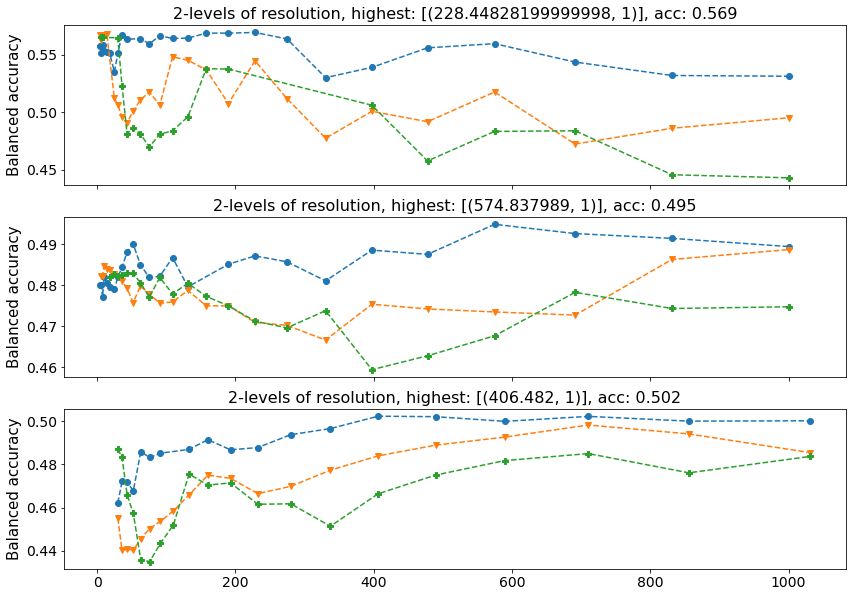

In [47]:
fig, ax = plt.subplots(3, 1 , figsize=(14, 10), sharex=True)
_ = plot_resolution(df_ddf1[(df_ddf1["stack"]==2)], ax[0], "mean_cv", stack=2, prev_resolution="")
_ = plot_resolution(df_wdf1[(df_wdf1["stack"]==2)], ax[1], "mean_cv", stack=2, prev_resolution="")
_ = plot_resolution(df11[(df11["stack"]==2)], ax[2], "mean_cv", stack=2, prev_resolution="")

In [3]:
print(file2)
df2 = pd.read_csv(os.path.join(folder, file2))
grouped_df2 = df2.groupby(["top-k"])
idxs = grouped_df2["mean_cv"].transform(max) == df2["mean_cv"]
max_df2 = df2[idxs]
max_df2

multi_ress_(TrMmMn-MmVaMx)_20210914-031605.csv


,top-k,stack,base,wl,win,dropped,shape_before,shape_after,mean_cv,std_cv,exp_var,n_comp,scheme
12,1,2,[(win:wl)-(160.245:1)-(1031.093:1)],1,1031.093,0,-1,-1,0.497268,0.028114,-1.0,362,ltc
85,2,2,[(win:wl)-(232.534:1)-(589.853:1)],1,589.853,0,-1,-1,0.492346,0.029756,-1.0,362,ltc
171,3,3,[(win:wl)-(110.428:1)-(710.551:1)-(710.551:2)],2,710.551,0,-1,-1,0.499328,0.030221,-1.0,362,ltc
240,4,3,[(win:wl)-(489.657:1)-(91.671:1)-(589.853:1)],1,589.853,0,-1,-1,0.498352,0.029370,-1.0,362,ltc


In [4]:
print(file1)
df1 = pd.read_csv(os.path.join(folder, file1))
grouped_df1 = df1.groupby(["top-k"])
idxs = grouped_df1["mean_cv"].transform(max) == df1["mean_cv"]
max_df1 = df1[idxs]
max_df1

multi_ress_(TrMm-MmMn-MmMx-TrMn)_20210914-031605.csv


,top-k,stack,base,wl,win,dropped,shape_before,shape_after,mean_cv,std_cv,exp_var,n_comp,scheme
82,1,3,[(win:wl)-(110.428:1)-(406.482:1)-(710.551:3)],3,710.551,0,-1,-1,0.508945,0.018823,-1.0,362,ltc
180,2,3,[(win:wl)-(160.245:1)-(855.946:2)-(91.671:1)],1,91.671,0,-1,-1,0.504430,0.017881,-1.0,362,ltc
297,3,3,[(win:wl)-(232.534:1)-(855.946:2)-(91.671:1)],1,91.671,0,-1,-1,0.508780,0.018534,-1.0,362,ltc
430,4,2,[(win:wl)-(193.035:1)-(855.946:2)],2,855.946,0,-1,-1,0.496196,0.015448,-1.0,362,ltc


In [8]:
R = [(110.428, 1), (406.482, 1), (710.551, 3)]
doc_kw = {
        "irr_handler": "#",
        "mean_bp_dist": "normal",
        "verbose": True,
    }

lsa_kw = {  # scheme: ltc
        "class_based": False,  # options: True, False
        "normalize": "l2",  # options: None, l2
        "use_idf": True,  # options: True, False
        "sublinear_tf": True  # options: True, False
    }
C = "LSA"
    
method = MMMBOPF(alpha=4, Q=None, Q_code="(TrMm-MmMn-MmMx-TrMn)", R=R, C=C, lsa_kw=lsa_kw, doc_kw=doc_kw, N=362, drop_zero_variance=False)

In [9]:
method.config_to_json(os.path.join(data_path, "optimal_config_lsa.json"))

config saving data to json:
alpha: 4 <class 'int'>
Q: [['trend', 'min_max'], ['min_max', 'min'], ['min_max', 'max'], ['trend', 'min']] <class 'list'>
R: [(110.428, 1), (406.482, 1), (710.551, 3)] <class 'list'>
docKwargs: {'irr_handler': '#', 'mean_bp_dist': 'normal', 'verbose': True, 'quantity': [], 'alphabet_size': []} <class 'dict'>
lsaKwargs: {'class_based': False, 'normalize': 'l2', 'use_idf': True, 'sublinear_tf': True} <class 'dict'>
N: 362 <class 'int'>
K: 0 <class 'int'>
maxDropped: default <class 'str'>
C: LSA <class 'str'>
dropZeroVariance: False <class 'bool'>


In [23]:
def get_dataset_variables(dataset_name):
    # read dataset
    dataset, labels_, metadata, split_folds = gen_dataset_from_h5(dataset_name, bands=_BANDS, num_folds=5)
    split_folds = rearrange_splits(split_folds)
    classes = np.unique(labels_)
    print(len(labels_))
    N = int(np.mean([len(ts[0]) * 2 for ts in dataset]))

    return dataset, labels_, metadata, split_folds, classes, N

In [27]:
_BANDS = ["lsstg", "lssti", "lsstr", "lsstu", "lssty", "lsstz"]
_, _, _, _, _, N = get_dataset_variables("plasticc_train")
print(N)

Object: 100%|█████████████████████████████████████████████████████████████████████| 7848/7848 [00:14<00:00, 524.17it/s]

7848
362
